In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Feature engineering and modeling notebook. Will split data into modeling and holdoff data, engineer features, create models and evaulate in this notebook.

In [2]:
# Import aggregated data
data = "Aggregated_Data.csv"

df = pd.read_csv(data)

In [3]:
# DataFrame Head
df.head()

,DATE,QDSQ,LAT,LON,COMNAME,KEPT,ASM,LIVEWT
0,1999-01-01,35753,35.75,-75.25,BLUEFISH,0,0,176.0
1,1999-01-01,35753,35.75,-75.25,BLUEFISH,1,0,701.0
2,1999-01-01,35753,35.75,-75.25,"DOGFISH, SPINY",0,0,1863.0
3,1999-01-01,35753,35.75,-75.25,"FLOUNDER, SUMMER (FLUKE)",0,0,2467.0
4,1999-01-01,35753,35.75,-75.25,"FLOUNDER, SUMMER (FLUKE)",1,0,17345.0


In [4]:
# DataFrame shape
df.shape

(159916, 8)

In [5]:
# Date to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Extract year
df['YEAR'] = df['DATE'].dt.year

# Count rows per year
rows_per_year = df.groupby('YEAR').size().reset_index(name='ROW_COUNT')
print(rows_per_year)


    YEAR  ROW_COUNT
0   1999        672
1   2000       1250
2   2001       1503
3   2002       2835
4   2003       4908
5   2004       6468
6   2005      10875
7   2006       6510
8   2007       7014
9   2008       7425
10  2009       7813
11  2010       9847
12  2011      10788
13  2012       8753
14  2013       7285
15  2014       7414
16  2015       5928
17  2016       4434
18  2017       3821
19  2018       2577
20  2019       5065
21  2020       3308
22  2021       6529
23  2022       8401
24  2023       9040
25  2024       9121
26  2025        332


In [6]:
# Drop years with low coverage/incomplete coverage
# Define years to drop
years_to_drop = [1999, 2000, 2001, 2025]

# Filter df to keep only rows NOT in years_to_drop
df_filtered = df[~df['YEAR'].isin(years_to_drop)].copy()

# Check new shape
print(f"Rows before dropping: {len(df)}")
print(f"Rows after dropping: {len(df_filtered)}")

Rows before dropping: 159916
Rows after dropping: 156159


Split for dataset to predict on later

In [7]:
# Split off a holdout set for final prediction later
holdout_years = [2021, 2022, 2023, 2024]

# Holdout for real-world prediction
df_holdout = df_filtered[df_filtered['YEAR'].isin(holdout_years)].copy()

# Remaining data used for model training and internal testing
df_model = df_filtered[~df_filtered['YEAR'].isin(holdout_years)].copy()

print(f"Modeling data rows: {len(df_model)}")
print(f"Holdout prediction rows: {len(df_holdout)}")

Modeling data rows: 123068
Holdout prediction rows: 33091


In [8]:
df_model.head()

,DATE,QDSQ,LAT,LON,COMNAME,KEPT,ASM,LIVEWT,YEAR
3425,2002-01-01,35753,35.75,-75.25,BLUEFISH,1,0,11.0,2002
3426,2002-01-01,35753,35.75,-75.25,"DOGFISH, SMOOTH",0,0,98.0,2002
3427,2002-01-01,35753,35.75,-75.25,"DOGFISH, SPINY",0,0,506.0,2002
3428,2002-01-01,35753,35.75,-75.25,"FLOUNDER, SUMMER (FLUKE)",0,0,182.0,2002
3429,2002-01-01,35753,35.75,-75.25,"FLOUNDER, SUMMER (FLUKE)",1,0,5251.0,2002


Here we will normalize our datasets by stratum

In [9]:
# Extract month from datetime
df_model['MONTH'] = df_model['DATE'].dt.month

# Define stratum as unique combination of YEAR, MONTH, and QDSQ
df_model['STRATUM_ID'] = (
    df_model['YEAR'].astype(str) + "_" +
    df_model['MONTH'].astype(str).str.zfill(2) + "_" +
    df_model['QDSQ'].astype(str)
)

# Aggregate biomass by species per stratum
stratum_species = (
    df_model.groupby(['STRATUM_ID', 'COMNAME'])['LIVEWT']
    .sum()
    .reset_index()
    .pivot(index='STRATUM_ID', columns='COMNAME', values='LIVEWT')
    .fillna(0)
)

# Normalize by row to get percent composition
stratum_composition = stratum_species.div(stratum_species.sum(axis=1), axis=0)

# Create metadata for each stratum with YEAR, MONTH, and QDSQ
stratum_metadata = (
    df_model.groupby('STRATUM_ID')
    .agg({
        'YEAR': 'first',
        'MONTH': 'first',
        'QDSQ': 'first'
    })
)

print(stratum_species.shape, stratum_composition.shape, stratum_metadata.shape)

(4572, 33) (4572, 33) (4572, 3)


In [10]:
# Print first 5 rows of raw biomass per stratum
print("Raw biomass (stratum_species) sample:")
print(stratum_species.head())

# Print first 5 rows of composition (% biomass) per stratum
print("\nComposition (stratum_composition) sample:")
print(stratum_composition.head())

# Print first 5 rows of metadata per stratum
print("\nStratum metadata sample:")
print(stratum_metadata.head())


Raw biomass (stratum_species) sample:
COMNAME        BASS, STRIPED  BLUEFISH  COD, ATLANTIC  DOGFISH, SMOOTH  \
STRATUM_ID                                                               
2002_01_35753            0.0      11.0            0.0             98.0   
2002_01_36751            0.0     127.5            0.0            147.0   
2002_01_36753            0.0     207.0            0.0              0.0   
2002_01_39724            0.0     338.0            0.0              4.0   
2002_01_41693            0.0       0.0         1978.0              0.0   

COMNAME        DOGFISH, SPINY  FLOUNDER, FOURSPOT  FLOUNDER, PLAICE, AMERICAN  \
STRATUM_ID                                                                      
2002_01_35753           506.0                 0.0                         0.0   
2002_01_36751           332.0                 0.0                         0.0   
2002_01_36753          3234.0                 0.0                         0.0   
2002_01_39724            28.0         

In [11]:
# Extract year and month
df_holdout['DATE'] = pd.to_datetime(df_holdout['DATE'])
df_holdout['YEAR'] = df_holdout['DATE'].dt.year
df_holdout['MONTH'] = df_holdout['DATE'].dt.month

# Define stratum as unique combination of YEAR, MONTH, and QDSQ
df_holdout['STRATUM_ID'] = (
    df_holdout['YEAR'].astype(str) + "_" +
    df_holdout['MONTH'].astype(str).str.zfill(2) + "_" +
    df_holdout['QDSQ'].astype(str)
)

# Aggregate biomass by species per stratum
stratum_species_holdout = (
    df_holdout.groupby(['STRATUM_ID', 'COMNAME'])['LIVEWT']
    .sum()
    .reset_index()
    .pivot(index='STRATUM_ID', columns='COMNAME', values='LIVEWT')
    .fillna(0)
)

# Normalize by row to get percent composition
stratum_composition_holdout = stratum_species_holdout.div(stratum_species_holdout.sum(axis=1), axis=0)

# Create metadata for each stratum with YEAR, MONTH, and QDSQ
stratum_metadata_holdout = (
    df_holdout.groupby('STRATUM_ID')
    .agg({
        'YEAR': 'first',
        'MONTH': 'first',
        'QDSQ': 'first'
    })
)

print(stratum_species_holdout.shape, stratum_composition_holdout.shape, stratum_metadata_holdout.shape)

(1120, 33) (1120, 33) (1120, 3)


In [12]:
# Print first 5 rows of raw biomass per stratum for holdout
print("Holdout - Raw biomass (stratum_species_holdout) sample:")
print(stratum_species_holdout.head())

# Print first 5 rows of composition (% biomass) per stratum for holdout
print("\nHoldout - Composition (stratum_composition_holdout) sample:")
print(stratum_composition_holdout.head())

# Print first 5 rows of metadata per stratum for holdout
print("\nHoldout - Stratum metadata sample:")
print(stratum_metadata_holdout.head())

Holdout - Raw biomass (stratum_species_holdout) sample:
COMNAME        BASS, STRIPED  BLUEFISH  COD, ATLANTIC  DOGFISH, SMOOTH  \
STRATUM_ID                                                               
2021_01_41683            0.0       0.0          430.1              0.0   
2021_01_41694            0.0       0.0          594.0              0.0   
2021_01_42671            0.0       0.0          497.3              0.0   
2021_01_42672            0.0       0.0          388.5              0.0   
2021_01_42681            0.0       0.0         1036.4              0.0   

COMNAME        DOGFISH, SPINY  FLOUNDER, FOURSPOT  FLOUNDER, PLAICE, AMERICAN  \
STRATUM_ID                                                                      
2021_01_41683             6.2                 4.7                       333.3   
2021_01_41694            10.9                11.2                       536.9   
2021_01_42671            37.0                11.8                        11.7   
2021_01_42672       

In [13]:
# Sum composiotion percentages per straum row in model
row_sums_model = stratum_composition.sum(axis=1)

# pring first 10 sums to check they're = 1
print(row_sums_model.head(10))


STRATUM_ID
2002_01_35753    1.0
2002_01_36751    1.0
2002_01_36753    1.0
2002_01_39724    1.0
2002_01_41693    1.0
2002_01_41694    1.0
2002_01_42703    1.0
2002_01_42704    1.0
2002_02_42703    1.0
2002_03_42703    1.0
dtype: float64


In [14]:
# Sum composition percentages per stratum row in holdout
row_sums = stratum_composition_holdout.sum(axis=1)

# Print first 10 sums to check they’re 1
print(row_sums.head(10))

STRATUM_ID
2021_01_41683    1.0
2021_01_41694    1.0
2021_01_42671    1.0
2021_01_42672    1.0
2021_01_42681    1.0
2021_01_42683    1.0
2021_01_42684    1.0
2021_01_42691    1.0
2021_01_42692    1.0
2021_01_42693    1.0
dtype: float64


Unsupervisered learning models will be used for clustering. I aim to try Kmeans, Heirarchal clustering and possibly a third

KMeans model

In [15]:
# Species composition as input for clustering
X = stratum_composition.copy()

In [16]:
# 5 clusters to start
k = 5

# Fit the model
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Add cluster labels to metadata
stratum_metadata['KMEANS_CLUSTER'] = kmeans_labels

In [17]:
stratum_metadata['KMEANS_CLUSTER'].value_counts()

KMEANS_CLUSTER
0    1280
2    1125
3     895
4     733
1     539
Name: count, dtype: int64

In [18]:
# Get cluster centers (each is a species composition vector)
cluster_profiles = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

# Preview the first 10 profiles
cluster_profiles.T.head(10)

,0,1,2,3,4
COMNAME,,,,,
"BASS, STRIPED",0.001441,0.000313,0.001680,0.000024,1.807055e-07
BLUEFISH,0.001326,0.000066,0.003047,0.000673,1.398871e-05
"COD, ATLANTIC",0.033699,0.063617,0.159468,0.026125,3.187237e-02
"DOGFISH, SMOOTH",0.003116,0.000044,0.003901,0.000371,1.372971e-06
"DOGFISH, SPINY",0.033157,0.035078,0.188396,0.033906,5.514509e-02
"FLOUNDER, FOURSPOT",0.003466,0.000579,0.003044,0.001597,1.567430e-04
"FLOUNDER, PLAICE, AMERICAN",0.007671,0.023280,0.029573,0.056332,4.937027e-02
"FLOUNDER, SUMMER (FLUKE)",0.043687,0.001569,0.116034,0.015507,7.388279e-06
"FLOUNDER, WINDOWPANE (SAND DAB)",0.015627,0.002259,0.006497,0.000218,1.374834e-04


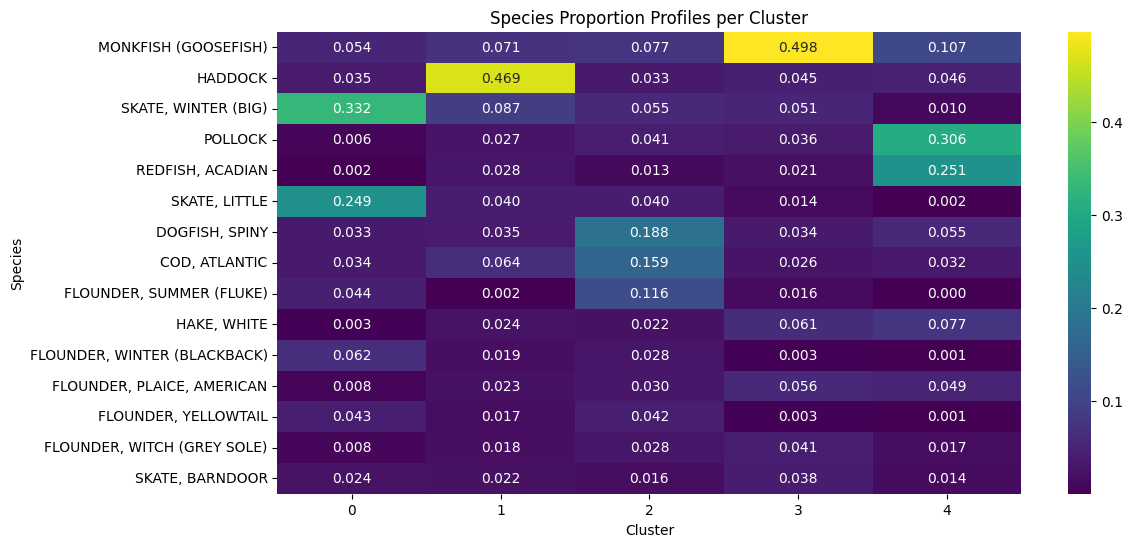

In [ ]:
# Select top species by max proportion across clusters
top_species = cluster_profiles.max(axis=0).sort_values(ascending=False).head(15).index

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles[top_species].T, cmap='viridis', annot=True, fmt=".3f")
plt.title('Species Proportion Profiles per Cluster')
plt.ylabel('Species')
plt.xlabel('Cluster')
plt.show()

In [20]:
stratum_metadata.head()

,YEAR,MONTH,QDSQ,KMEANS_CLUSTER
STRATUM_ID,,,,
2002_01_35753,2002,1,35753,2
2002_01_36751,2002,1,36751,2
2002_01_36753,2002,1,36753,2
2002_01_39724,2002,1,39724,2
2002_01_41693,2002,1,41693,2


In [ ]:
# Map LAT and LON to qdsq for meta data
# Step 1: Extract one row per QDSQ with its LAT and LON
qdsq_coords = df[['QDSQ', 'LAT', 'LON']].drop_duplicates()

# Step 2: Join lat/lon to stratum metadata
metadata_with_coords = (
    stratum_metadata
    .reset_index()  # bring STRATUM_ID into columns
    .merge(qdsq_coords, on='QDSQ', how='left')  # attach spatial info
)

In [22]:
# Add seasons for visuals
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

metadata_with_coords['SEASON'] = metadata_with_coords['MONTH'].apply(get_season)

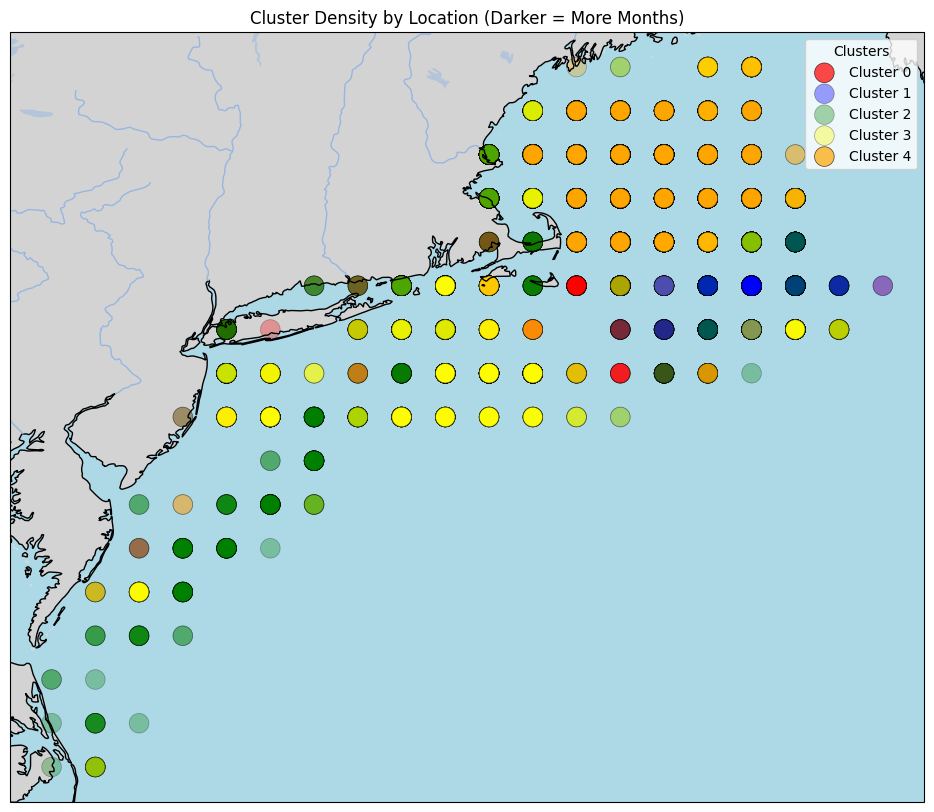

In [ ]:
# Step 1: Count how many strata (months) per QDSQ per cluster
cluster_counts = (
    metadata_with_coords
    .groupby(['QDSQ', 'KMEANS_CLUSTER'])
    .size()
    .reset_index(name='MONTH_COUNT')
)

# Step 2: Normalize the count for use in alpha scaling (between 0.3 and 1.0)
max_count = cluster_counts['MONTH_COUNT'].max()
cluster_counts['ALPHA'] = 0.3 + 0.7 * (cluster_counts['MONTH_COUNT'] / max_count)

# Step 3: Merge alpha values back to metadata
metadata_with_alpha = metadata_with_coords.merge(
    cluster_counts[['QDSQ', 'KMEANS_CLUSTER', 'ALPHA']],
    on=['QDSQ', 'KMEANS_CLUSTER'],
    how='left'
)

# Step 4: Plot
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines(resolution='10m')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

cluster_colors = ['red', 'blue', 'green', 'yellow', 'orange']
num_clusters = metadata_with_alpha['KMEANS_CLUSTER'].nunique()

for cluster_id in range(num_clusters):
    cluster_data = metadata_with_alpha[metadata_with_alpha['KMEANS_CLUSTER'] == cluster_id]
    color = cluster_colors[cluster_id % len(cluster_colors)]

    ax.scatter(
        cluster_data['LON'], cluster_data['LAT'],
        color=color,
        label=f'Cluster {cluster_id}',
        alpha=cluster_data['ALPHA'],  # <-- Vary alpha here
        s=200,
        edgecolor='k',
        linewidth=0.5,
        transform=ccrs.PlateCarree()
    )

plt.legend(title='Clusters')
plt.title('Cluster Density by Location (Darker = More Months)')
plt.show()

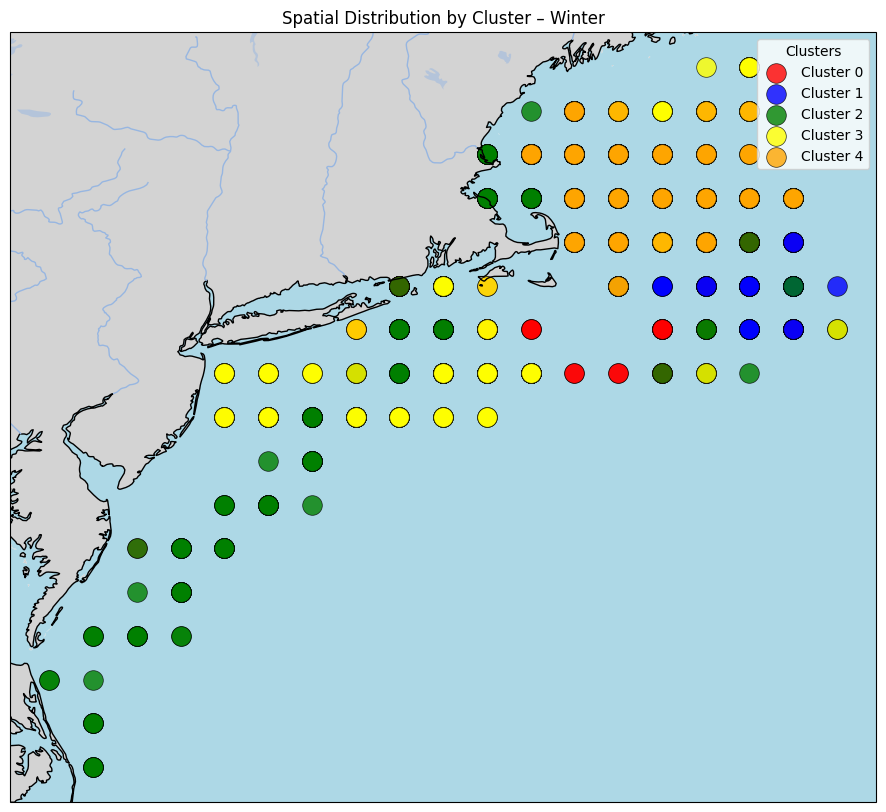

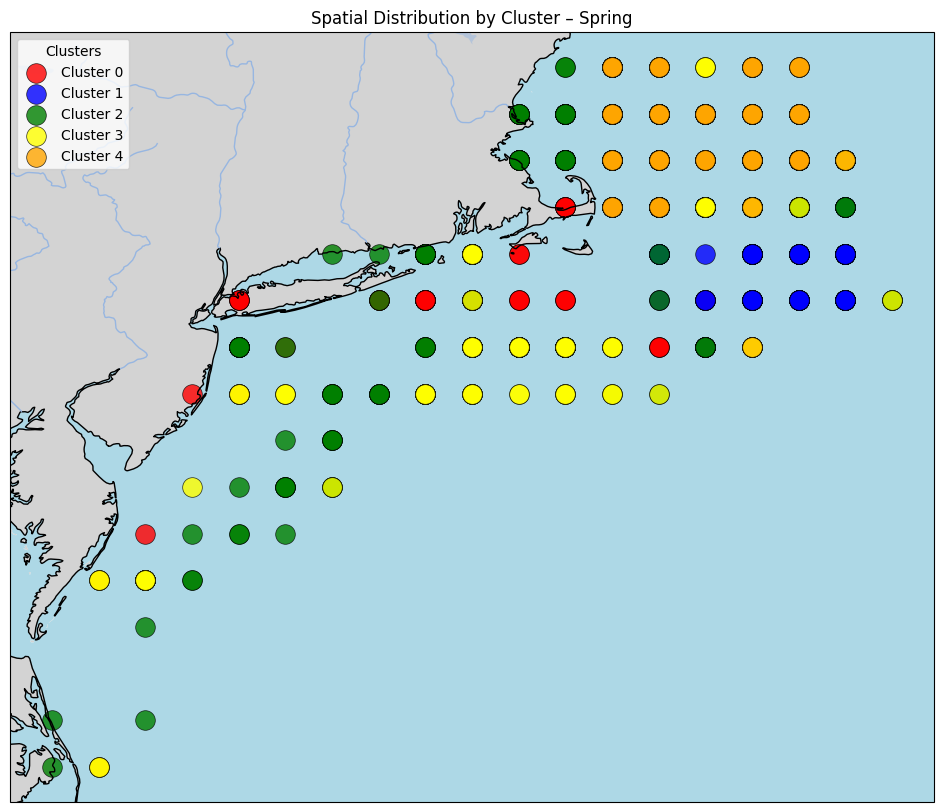

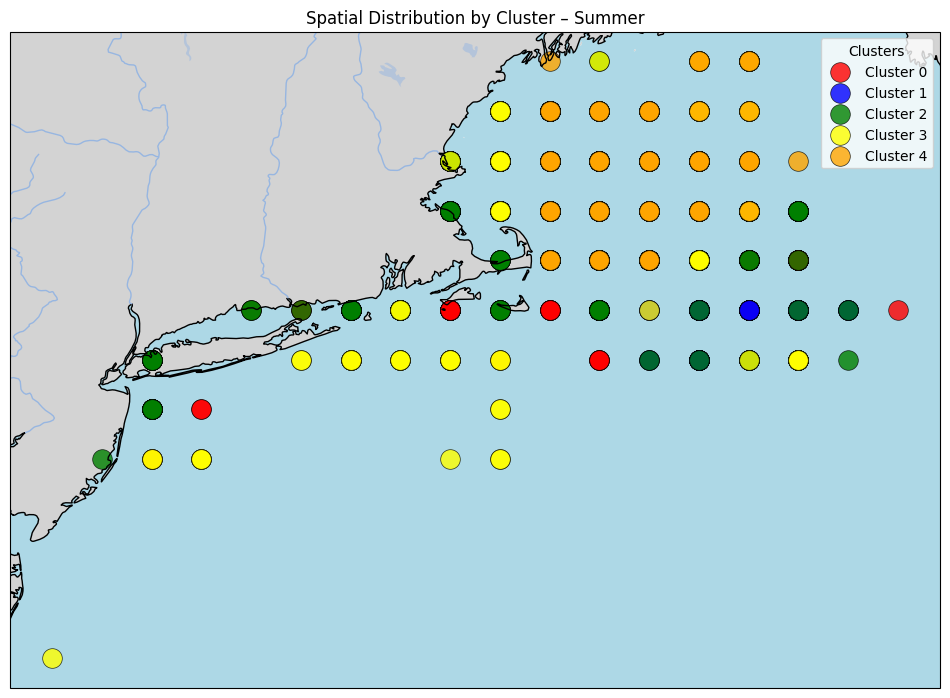

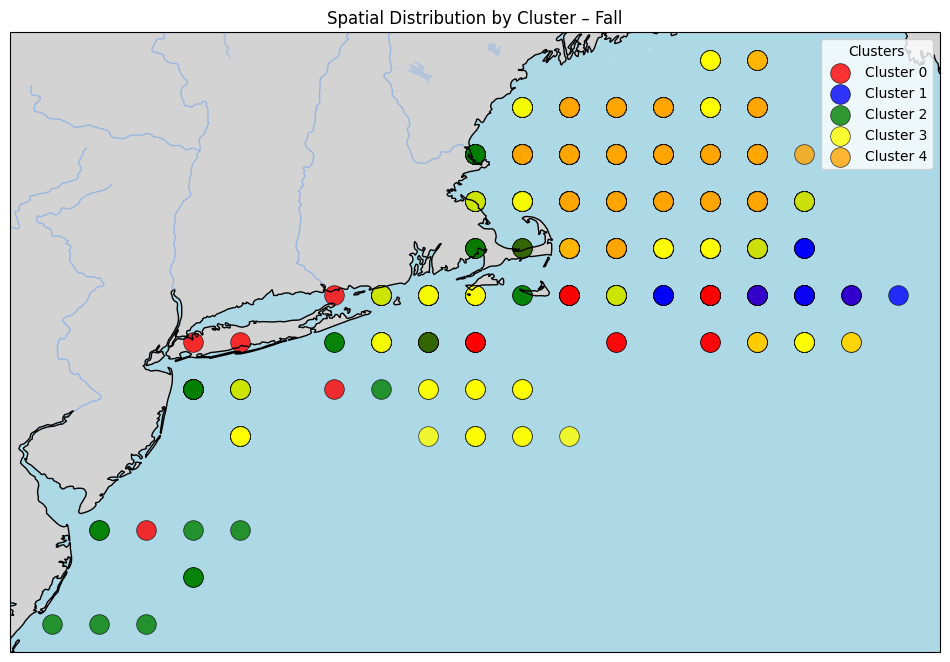

In [24]:
# New maps based on season to clarify clusters
# Define cluster color palette 
cluster_colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'brown']

# Cluster column
cluster_col = 'KMEANS_CLUSTER'  

# Seasons to plot
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

for season in seasons:
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    season_data = metadata_with_coords[metadata_with_coords['SEASON'] == season]
    unique_clusters = sorted(season_data[cluster_col].unique())

    for cluster_id in unique_clusters:
        cluster_data = season_data[season_data[cluster_col] == cluster_id]
        color = cluster_colors[cluster_id % len(cluster_colors)]
        ax.scatter(
            cluster_data['LON'], cluster_data['LAT'],
            color=color,
            label=f'Cluster {cluster_id}',
            alpha=0.8,
            s=200,
            edgecolor='k',
            linewidth=0.5,
            transform=ccrs.PlateCarree()
        )

    plt.legend(title='Clusters')
    plt.title(f'Spatial Distribution by Cluster – {season}')
    plt.show()


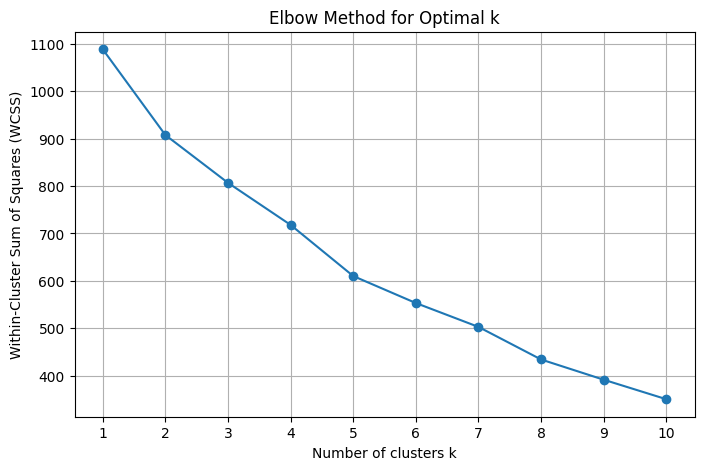

In [25]:
# Define range of k values to try
K_range = range(1, 11)

wcss = []

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    wcss.append(model.inertia_)  # inertia_ is WCSS

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()

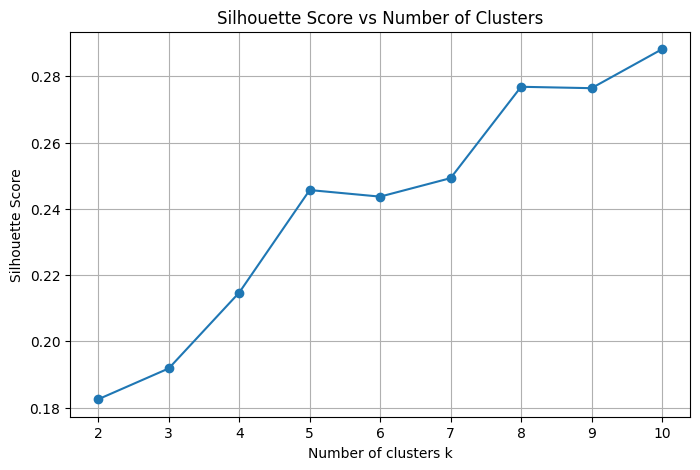

In [26]:
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [27]:
# Try k menans with 8 clusters
k = 8
model_8 = KMeans(n_clusters=k, random_state=42)
labels_8 = model_8.fit_predict(X)

metadata_with_coords['KMEANS_CLUSTER_8'] = labels_8

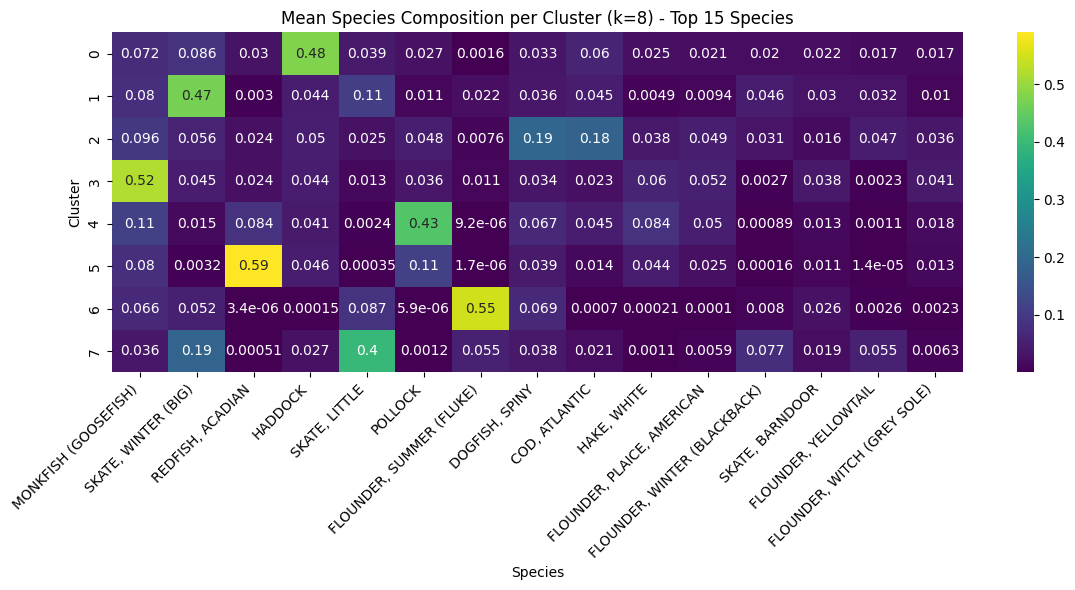

In [28]:
# Copy and lavel cluster
cluster_comp_8 = stratum_composition.copy()
cluster_comp_8['KMEANS_CLUSTER_8'] = metadata_with_coords.set_index('STRATUM_ID')['KMEANS_CLUSTER_8']

# Compute mean composition by cluster
mean_comp_8 = cluster_comp_8.groupby('KMEANS_CLUSTER_8').mean()

# Identify top 15 species by overall mean abundance
top_species_8 = mean_comp_8.mean().sort_values(ascending=False).head(15).index

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(mean_comp_8[top_species_8], cmap='viridis', annot=True)
plt.title('Mean Species Composition per Cluster (k=8) - Top 15 Species')
plt.ylabel('Cluster')
plt.xlabel('Species')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

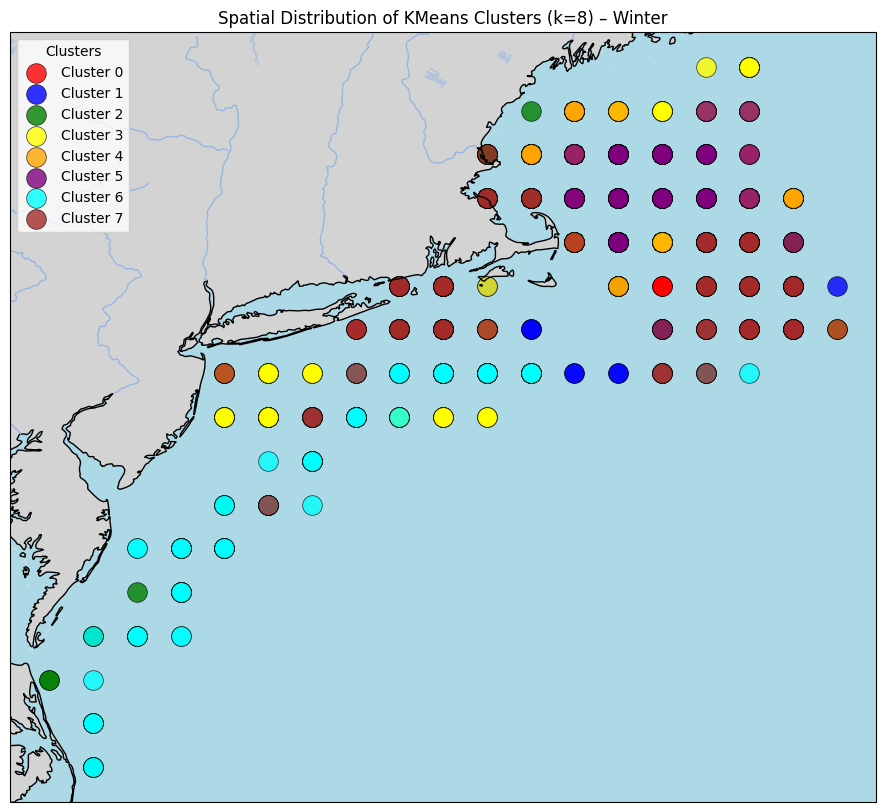

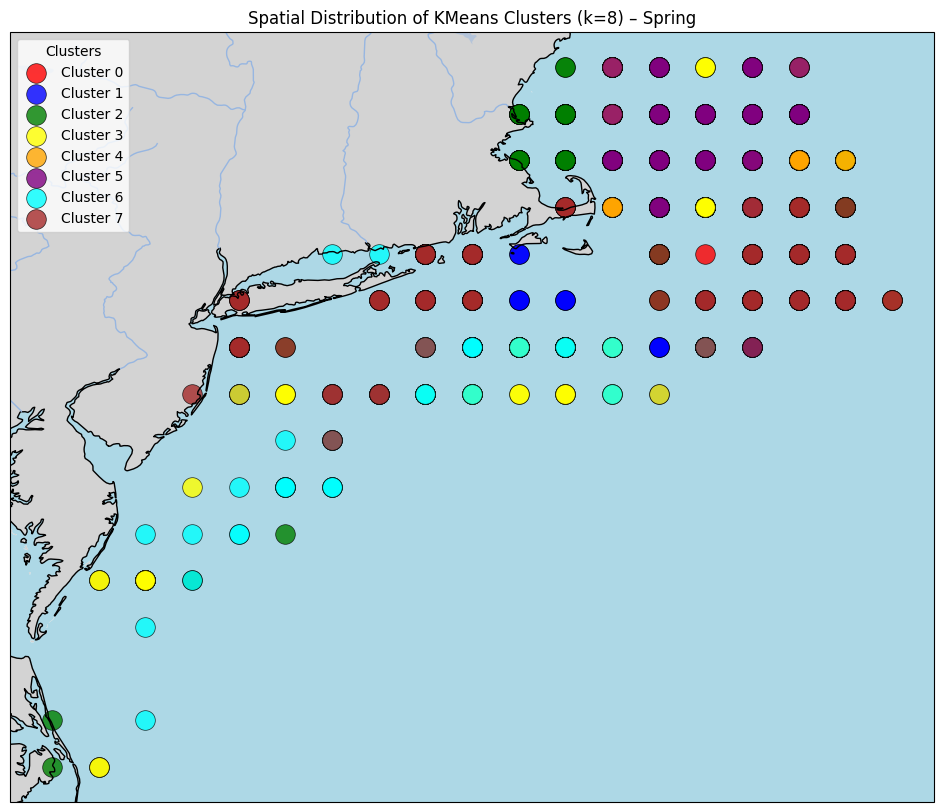

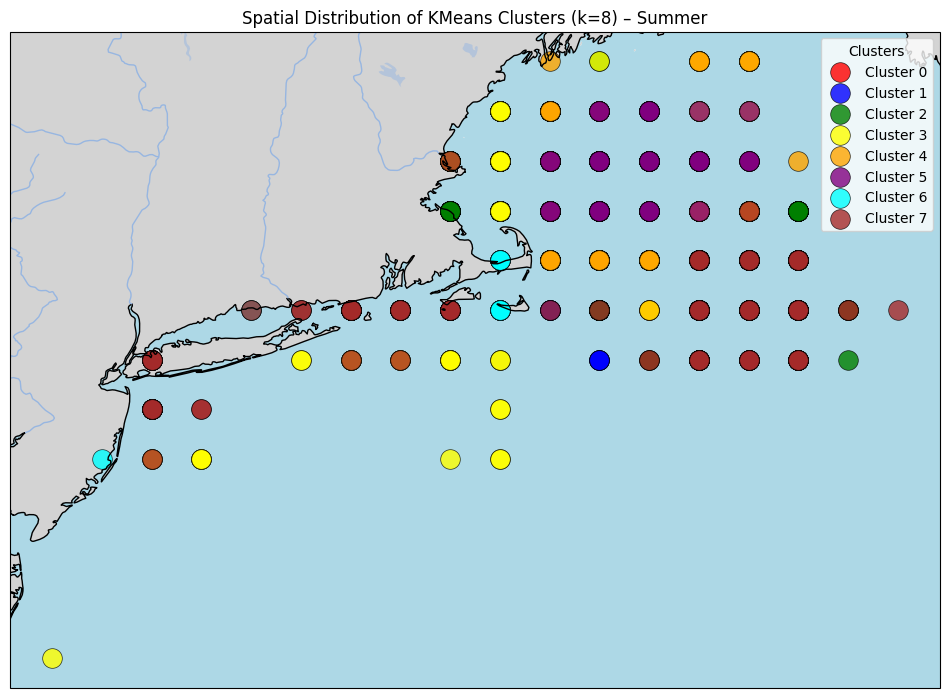

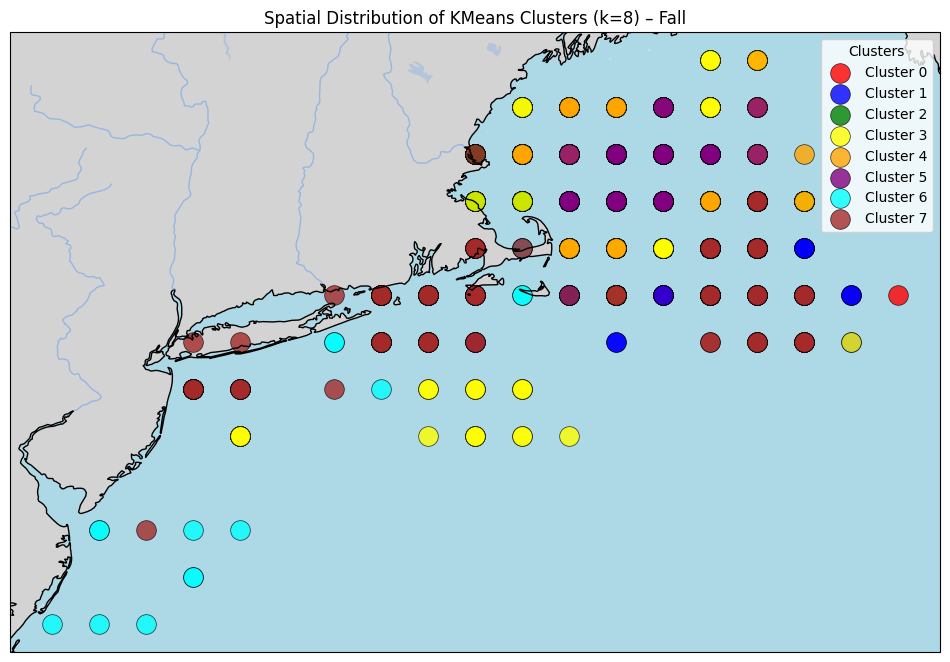

In [29]:
# Define cluster colors
cluster_colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'cyan', 'brown']

for season in seasons:
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # Filter metadata to the current season
    season_data = metadata_with_coords[metadata_with_coords['SEASON'] == season]
    unique_clusters = sorted(season_data['KMEANS_CLUSTER_8'].unique())

    for cluster_id in unique_clusters:
        cluster_data = season_data[season_data['KMEANS_CLUSTER_8'] == cluster_id]
        color = cluster_colors[cluster_id % len(cluster_colors)]
        ax.scatter(
            cluster_data['LON'], cluster_data['LAT'],
            color=color,
            label=f'Cluster {cluster_id}',
            alpha=0.8,
            s=200,
            edgecolor='k',
            linewidth=0.5,
            transform=ccrs.PlateCarree()
        )

    plt.legend(title='Clusters')
    plt.title(f'Spatial Distribution of KMeans Clusters (k=8) – {season}')
    plt.show()

In [30]:
# Make sure input features (X) exclude cluster labels
X = stratum_composition.copy()

# Cluster labels for k=5 and k=8
labels_5 = metadata_with_coords.set_index('STRATUM_ID')['KMEANS_CLUSTER']
labels_8 = metadata_with_coords.set_index('STRATUM_ID')['KMEANS_CLUSTER_8']

# Align index just in case
X = X.loc[labels_5.index]

# Metrics for k=5
print("=== K = 5 ===")
print(f"Silhouette Score:       {silhouette_score(X, labels_5):.3f}")
print(f"Calinski-Harabasz Score:{calinski_harabasz_score(X, labels_5):.2f}")
print(f"Davies-Bouldin Score:   {davies_bouldin_score(X, labels_5):.3f}")

# Metrics for k=8
print("\n=== K = 8 ===")
print(f"Silhouette Score:       {silhouette_score(X, labels_8):.3f}")
print(f"Calinski-Harabasz Score:{calinski_harabasz_score(X, labels_8):.2f}")
print(f"Davies-Bouldin Score:   {davies_bouldin_score(X, labels_8):.3f}")


=== K = 5 ===
Silhouette Score:       0.246
Calinski-Harabasz Score:895.17
Davies-Bouldin Score:   1.663

=== K = 8 ===
Silhouette Score:       0.277
Calinski-Harabasz Score:982.83
Davies-Bouldin Score:   1.279


We evaluated KMeans clustering models with 5 and 8 clusters on the normalized species composition data. The model with 8 clusters performed better across key metrics—silhouette score, Calinski-Harabasz, and Davies-Bouldin—indicating more distinct and cohesive groupings. From a fisheries perspective, several clusters align well with known species associations, such as clusters containing little and big skates, or redfish and pollock, which are commonly caught together in the Gulf of Maine. Some clusters, like those involving haddock, show less clear co-occurrence patterns, likely due to gear selectivity and mixed-species catches inherent in commercial fishing. Overall, the results suggest that the 8-cluster model captures meaningful ecological structure while reflecting the complexities of the fishery data.

Hierarchal Clustering Model

In [31]:
X = stratum_composition.copy()

In [32]:
# Compute linke matrix using Wards method
Z = linkage(X, method='ward')

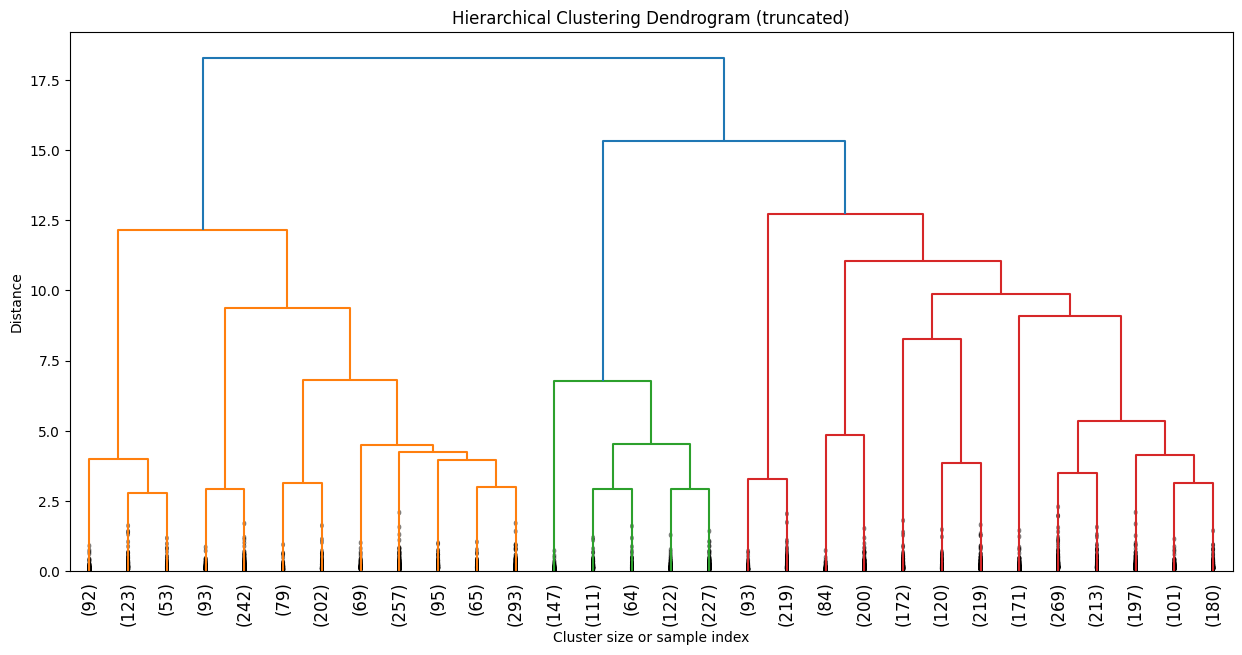

In [33]:
# Plot a truncated dendrogram to visually assess cluster structure
# 'truncate_mode=lastp' shows only the last p merged clusters for clarity
plt.figure(figsize=(15, 7))
dendrogram(
    Z,
    truncate_mode='lastp',  # Show only the last p merged clusters
    p=30,                   # Number of clusters to show
    leaf_rotation=90.,      # Rotate x-axis labels for readability
    leaf_font_size=12.,     # Font size for labels
    show_contracted=True    # Show contracted branches as triangles
)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Cluster size or sample index')
plt.ylabel('Distance')
plt.show()

In [34]:
# Try 8 clusters, based on Kmeans finding and visually looks like a good number that covers everything
# Cut the dendrogram at the height that results in 8 clusters
num_clusters = 8
hc_labels = fcluster(Z, num_clusters, criterion='maxclust')

In [35]:
metadata_with_coords['HC_CLUSTER_8'] = hc_labels

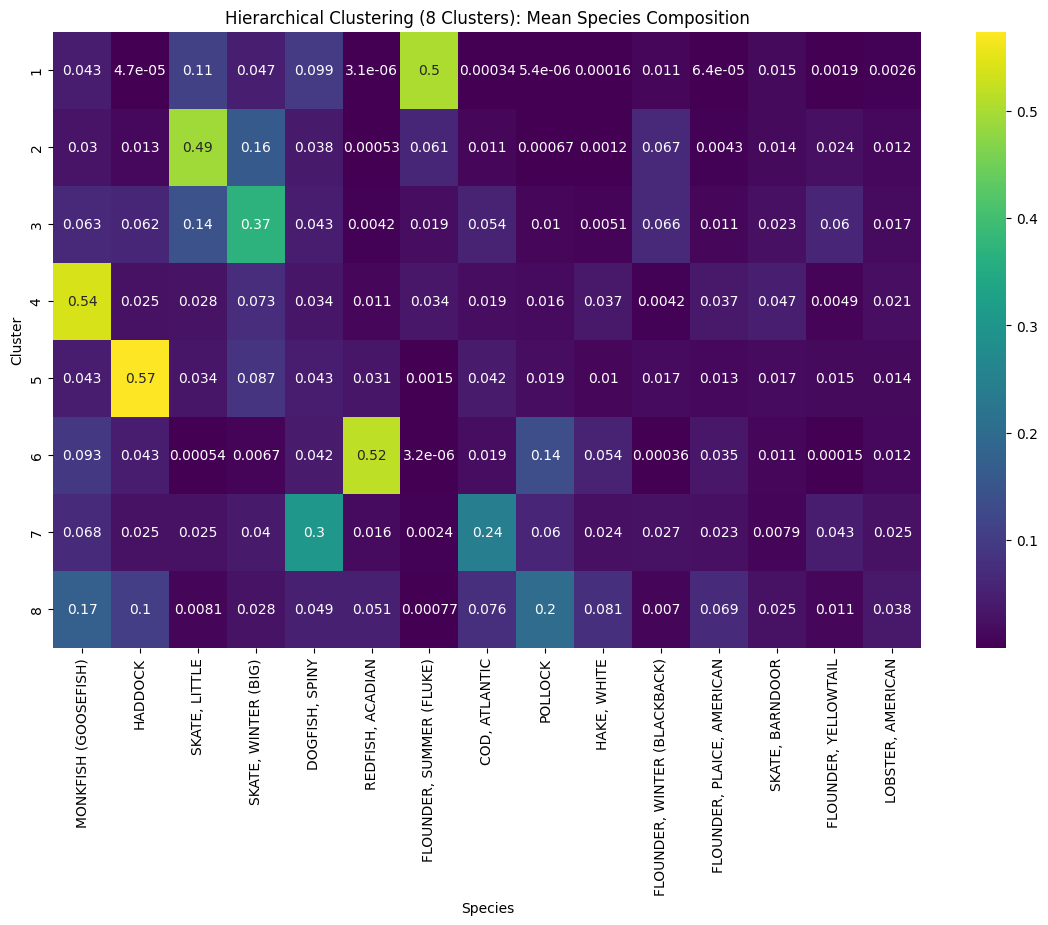

In [36]:
# Add the cluster labels to the species composition dataframe
cluster_comp_hc = stratum_composition.copy()
cluster_comp_hc['HC_CLUSTER_8'] = hc_labels

# Get mean composition per cluster
mean_comp_hc = cluster_comp_hc.groupby('HC_CLUSTER_8').mean()

# Optional: Limit to top species
top_species = mean_comp_hc.mean().sort_values(ascending=False).head(15).index

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(mean_comp_hc[top_species], cmap='viridis', annot=True)
plt.title('Hierarchical Clustering (8 Clusters): Mean Species Composition')
plt.xlabel('Species')
plt.ylabel('Cluster')
plt.show()


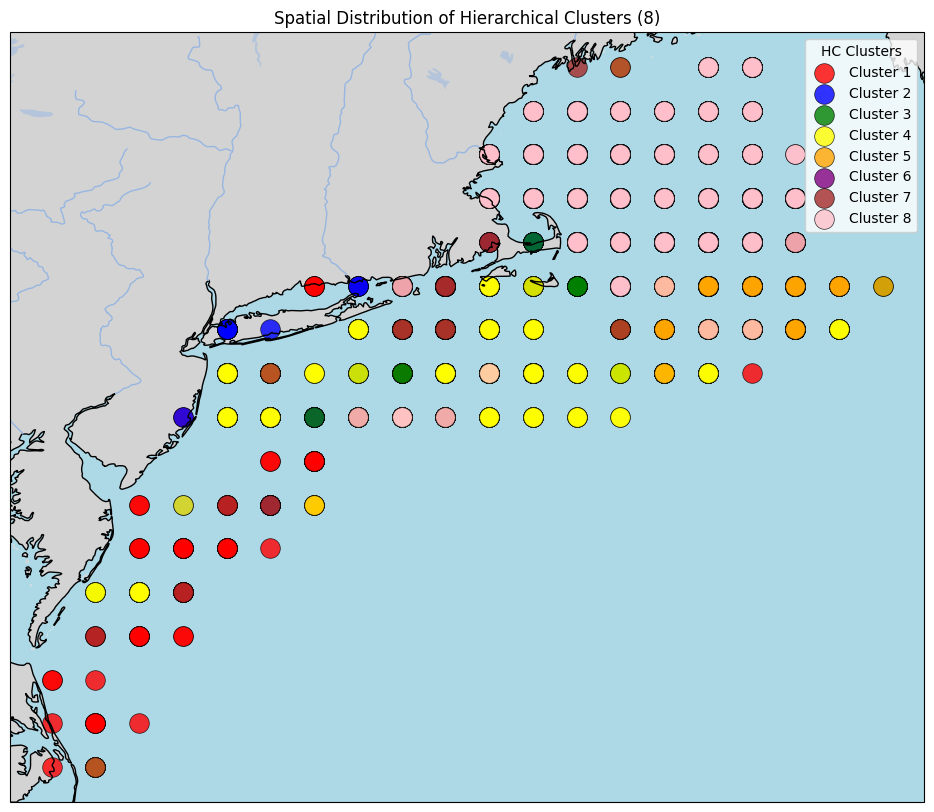

In [37]:
# Cartopy map
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines(resolution='10m')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Choose colors
cluster_colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'brown', 'pink']

# Plot each cluster
for cluster_id in range(1, num_clusters + 1):  # fcluster gives cluster labels starting from 1
    cluster_data = metadata_with_coords[metadata_with_coords['HC_CLUSTER_8'] == cluster_id]
    color = cluster_colors[(cluster_id - 1) % len(cluster_colors)]
    ax.scatter(
        cluster_data['LON'], cluster_data['LAT'],
        color=color,
        label=f'Cluster {cluster_id}',
        alpha=0.8,
        s=200,
        edgecolor='k',
        linewidth=0.5,
        transform=ccrs.PlateCarree()
    )

plt.legend(title='HC Clusters')
plt.title('Spatial Distribution of Hierarchical Clusters (8)')
plt.show()


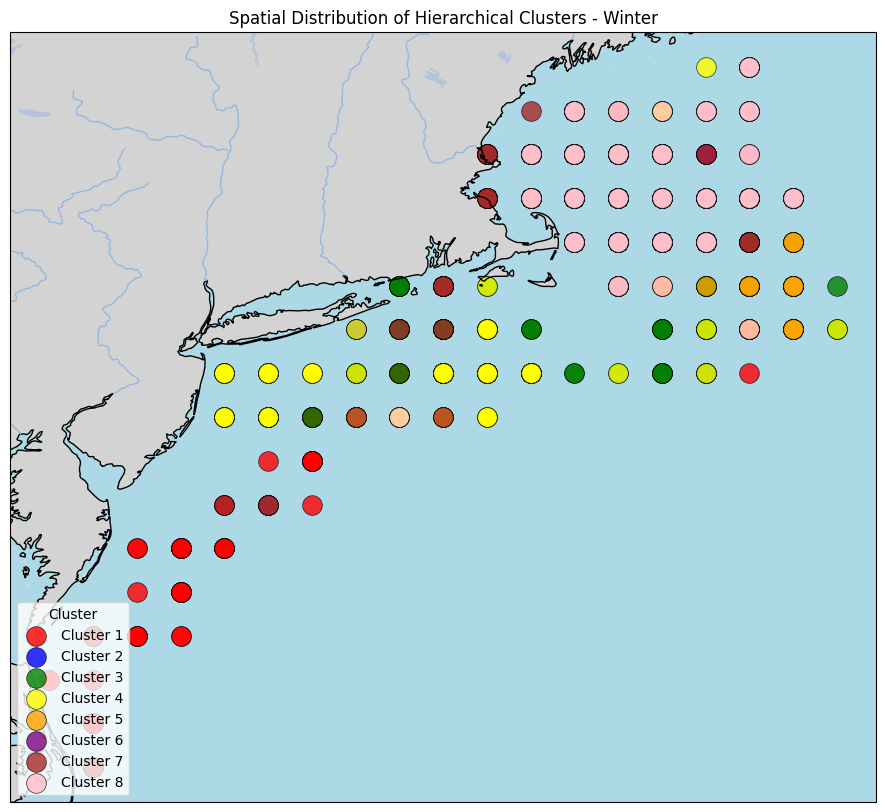

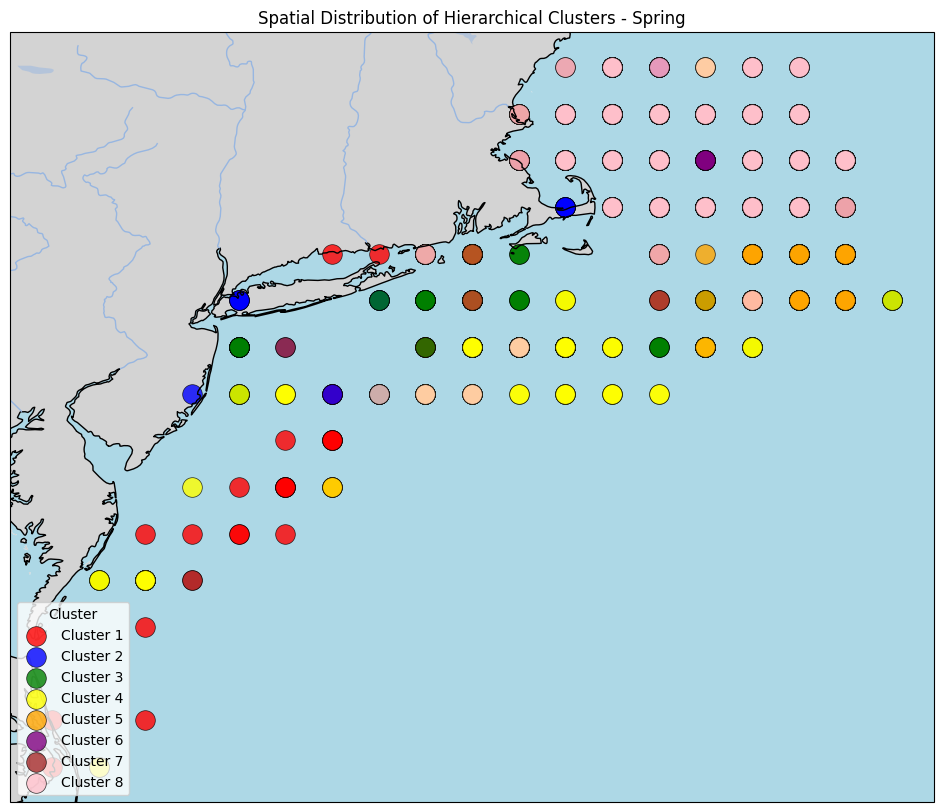

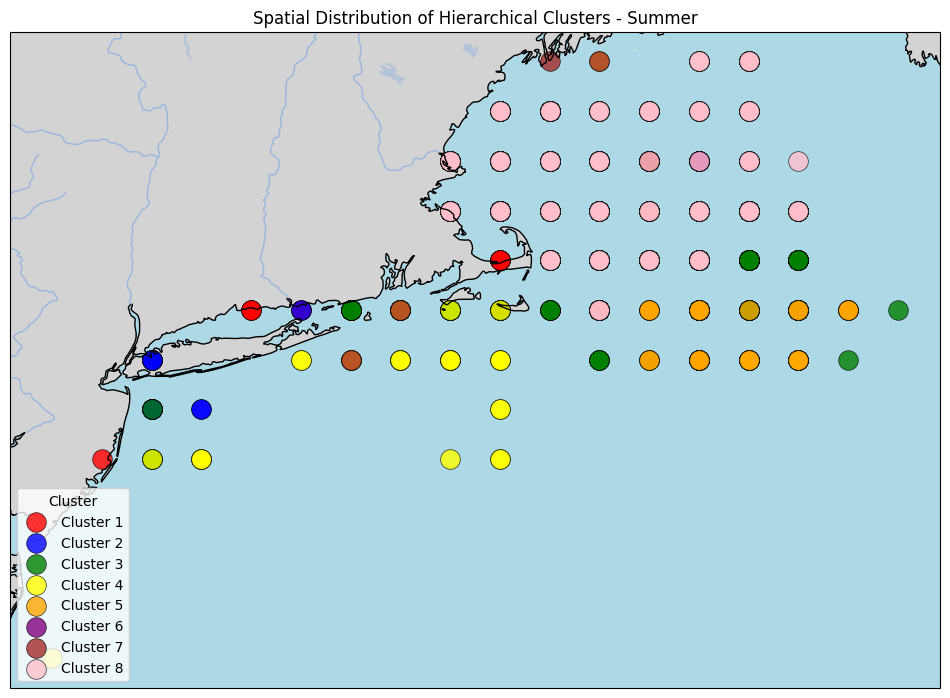

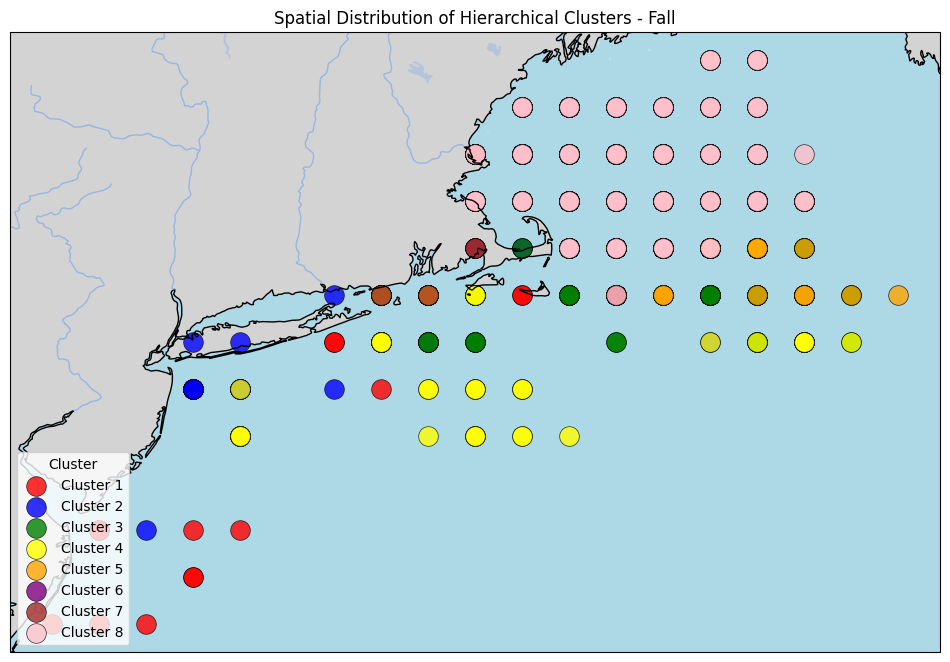

In [38]:
# Again but by season
# Cluster colors (same order as cluster labels 1–8)
cluster_colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'brown', 'pink']

season_map = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall':   [9, 10, 11]
}

# Make one plot per season
for season, months in season_map.items():
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # Filter metadata for this season
    season_data = metadata_with_coords[metadata_with_coords['MONTH'].isin(months)]

    # Plot each hierarchical cluster
    for cluster_id in range(1, 9):  # Cluster labels from fcluster start at 1
        cluster_data = season_data[season_data['HC_CLUSTER_8'] == cluster_id]
        color = cluster_colors[(cluster_id - 1) % len(cluster_colors)]
        ax.scatter(
            cluster_data['LON'], cluster_data['LAT'],
            color=color,
            label=f'Cluster {cluster_id}',
            alpha=0.8,
            s=200,
            edgecolor='k',
            linewidth=0.5,
            transform=ccrs.PlateCarree()
        )

    plt.title(f'Spatial Distribution of Hierarchical Clusters - {season}')
    plt.legend(title='Cluster', loc='lower left')
    plt.show()


In [39]:
# Quantitative metrics for Hierarchical Clustering (8 clusters)
print("=== Hierarchical Clustering Metrics (Clusters = 8) ===")
print(f"Silhouette Score:        {silhouette_score(X, hc_labels):.3f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X, hc_labels):.2f}")
print(f"Davies-Bouldin Score:    {davies_bouldin_score(X, hc_labels):.3f}")

=== Hierarchical Clustering Metrics (Clusters = 8) ===
Silhouette Score:        0.206
Calinski-Harabasz Score: 781.87
Davies-Bouldin Score:    1.424


In [40]:
# Compare models using adjusted rand score:
kmeans_labels = metadata_with_coords['KMEANS_CLUSTER_8']
hc_labels = metadata_with_coords['HC_CLUSTER_8']

ari = adjusted_rand_score(kmeans_labels, hc_labels)
print(f"Adjusted Rand Index (KMeans vs Hierarchical): {ari:.3f}")

Adjusted Rand Index (KMeans vs Hierarchical): 0.426


The hierarchical clustering model with 8 clusters revealed meaningful groupings of fish species composition across strata, capturing ecological patterns that align moderately well with domain knowledge. While the model’s quantitative metrics (Silhouette Score: 0.206, Calinski-Harabasz: 781.87, Davies-Bouldin: 1.424) are slightly lower than those of the KMeans model, it offers a valuable alternative perspective by illustrating nested relationships via its dendrogram structure. Comparison between the two methods using the Adjusted Rand Index (0.426) indicates moderate agreement, suggesting both models identify overlapping yet distinct community structures. Overall, KMeans provides more compact and well-separated clusters quantitatively, while hierarchical clustering offers interpretability and insights into the hierarchical organization of species assemblages. Together, these models complement each other in revealing the complexity of species co-occurrence in the fisheries data.

With Kmeans (k=8) superior preformance, I now apply it to the holdout dataset, which was set aside to evaluate generalizability and cluster stability on unseen data.

In [41]:
# Align columns in holdout to match training set
stratum_composition_holdout_aligned = stratum_composition_holdout.reindex(
    columns=stratum_composition.columns, 
    fill_value=0
)

In [45]:
# Predict using the trained model
holdout_clusters_8 = model_8.predict(stratum_composition_holdout_aligned)

# Assign to metadata
stratum_metadata_holdout = stratum_metadata_holdout.copy()
stratum_metadata_holdout['KMEANS_CLUSTER_8'] = holdout_clusters_8

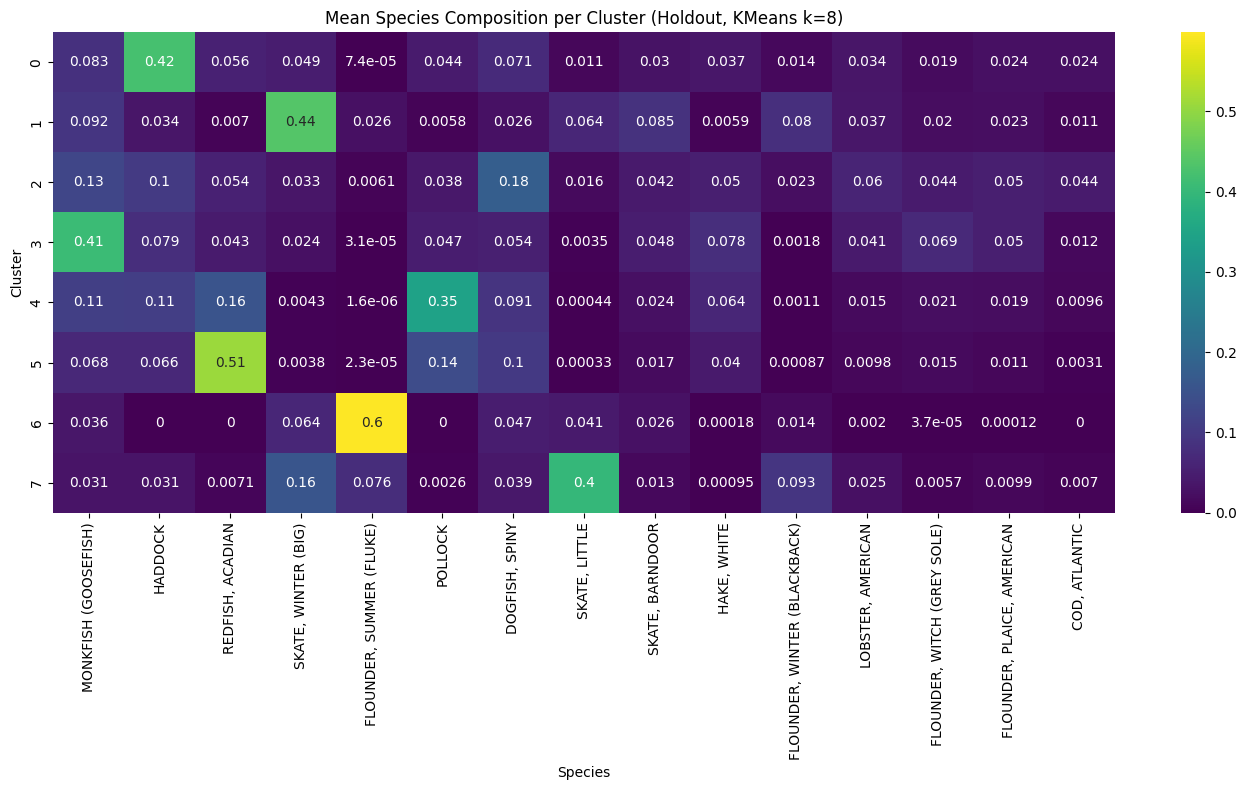

In [47]:
# Copy holdout composition and add KMeans cluster labels
cluster_comp_holdout = stratum_composition_holdout.copy()
cluster_comp_holdout['KMEANS_CLUSTER_8'] = stratum_metadata_holdout['KMEANS_CLUSTER_8']

# Calculate mean species composition per cluster
mean_comp_holdout = cluster_comp_holdout.groupby('KMEANS_CLUSTER_8').mean()

# Select top 15 species by average abundance
top_species = mean_comp_holdout.mean().sort_values(ascending=False).head(15).index

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(mean_comp_holdout[top_species], cmap='viridis', annot=True)
plt.title('Mean Species Composition per Cluster (Holdout, KMeans k=8)')
plt.xlabel('Species')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

Seeing similar clusters as before, pollock and redfish, gadid clusters, skates, and others.

In [50]:
# Create QDSQ to lat/lon mapping from the holdout original data
qdsq_coords = df_holdout[['QDSQ', 'LAT', 'LON']].drop_duplicates().set_index('QDSQ')

# Join lat/lon into stratum_metadata_holdout using QDSQ
stratum_metadata_holdout = stratum_metadata_holdout.join(qdsq_coords, on='QDSQ')

# Check if lat/lon are added
print(stratum_metadata_holdout[['LAT', 'LON']].head())

                 LAT    LON
STRATUM_ID                 
2021_01_41683  41.75 -68.25
2021_01_41694  41.75 -69.75
2021_01_42671  42.25 -67.25
2021_01_42672  42.25 -67.75
2021_01_42681  42.25 -68.25


In [53]:
# Add season column
stratum_metadata_holdout['SEASON'] = stratum_metadata_holdout['MONTH'].apply(get_season)

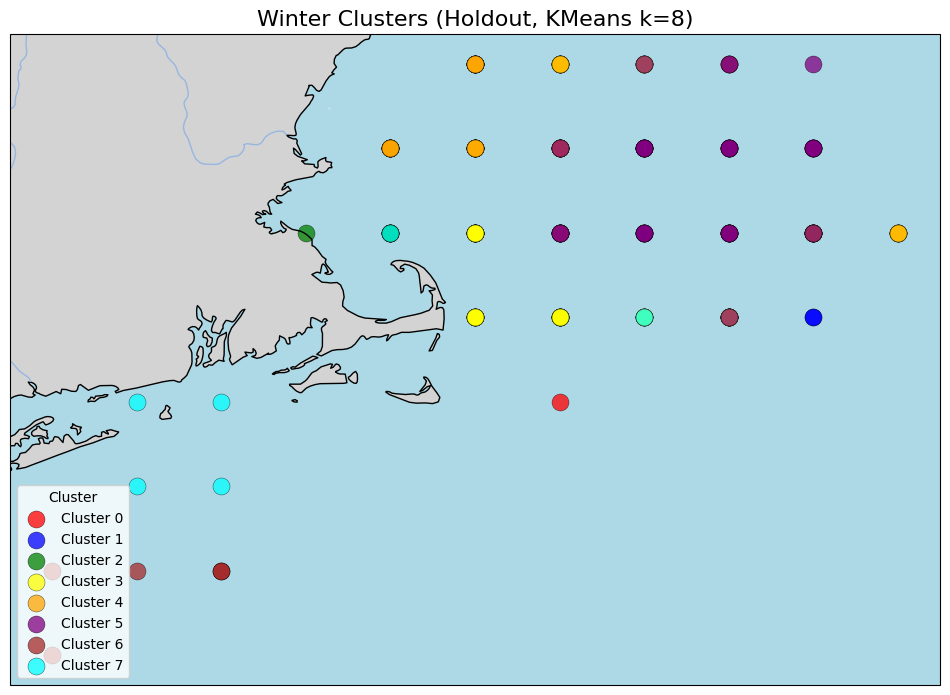

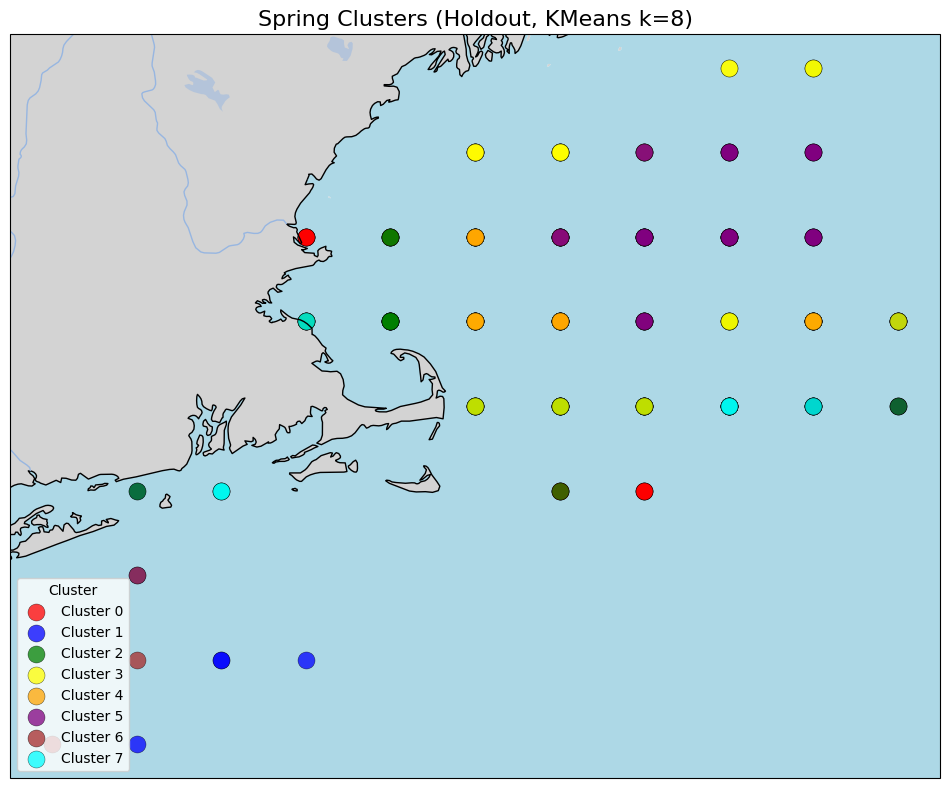

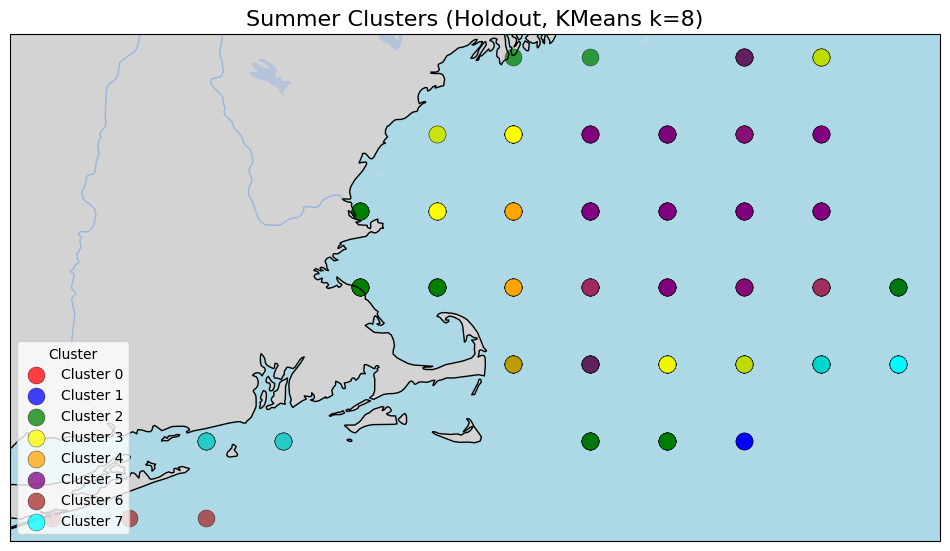

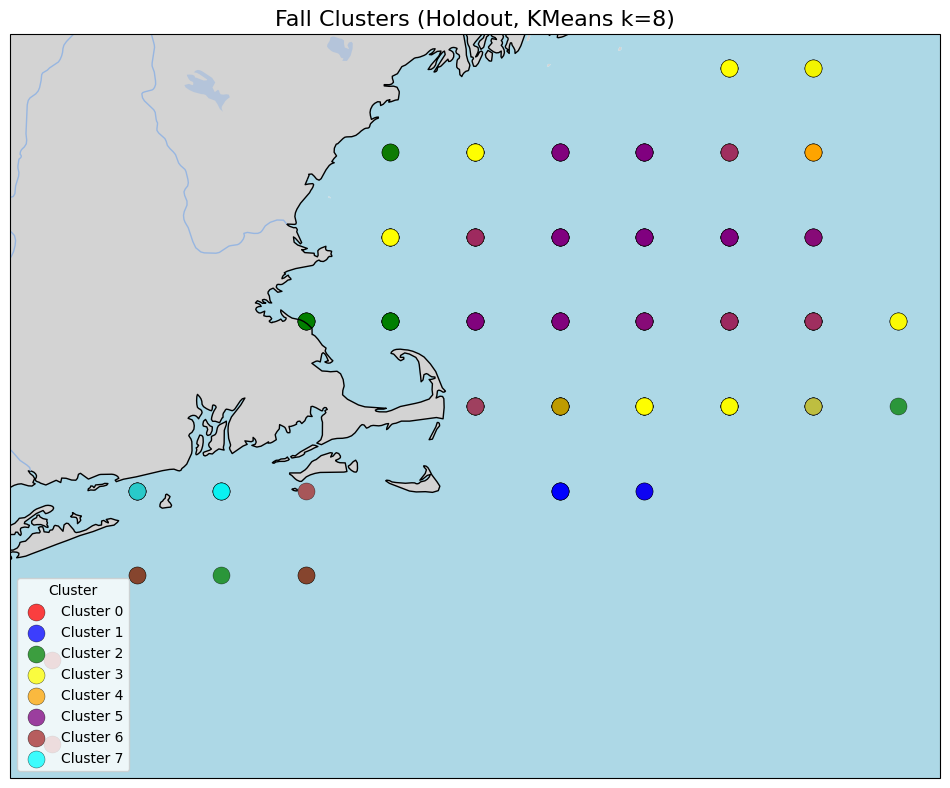

In [55]:
# Define colors for clusters
cluster_colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'brown', 'cyan']

# Define seasons
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

for season in seasons:
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title(f"{season} Clusters (Holdout, KMeans k=8)", fontsize=16)

    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    season_data = stratum_metadata_holdout[stratum_metadata_holdout['SEASON'] == season]

    for cluster_id in range(8):
        cluster_data = season_data[season_data['KMEANS_CLUSTER_8'] == cluster_id]
        color = cluster_colors[cluster_id % len(cluster_colors)]
        ax.scatter(
            cluster_data['LON'], cluster_data['LAT'],
            color=color,
            label=f'Cluster {cluster_id}',
            alpha=0.75,
            s=150,
            edgecolor='k',
            linewidth=0.3
        )
    ax.legend(title='Cluster', loc='lower left')
    plt.show()

In [56]:
# Prepare input features and labels for holdout
X_holdout = stratum_composition_holdout.copy()
labels_holdout = stratum_metadata_holdout['KMEANS_CLUSTER_8']

# Align indexes just in case
X_holdout = X_holdout.loc[labels_holdout.index]

print("=== Holdout Data KMeans Clustering Metrics (k=8) ===")
print(f"Silhouette Score:       {silhouette_score(X_holdout, labels_holdout):.3f}")
print(f"Calinski-Harabasz Score:{calinski_harabasz_score(X_holdout, labels_holdout):.2f}")
print(f"Davies-Bouldin Score:   {davies_bouldin_score(X_holdout, labels_holdout):.3f}")

=== Holdout Data KMeans Clustering Metrics (k=8) ===
Silhouette Score:       0.254
Calinski-Harabasz Score:240.53
Davies-Bouldin Score:   1.343


The holdout data clusters align well with our initial KMeans models, particularly the chosen k=8 solution, demonstrating consistent species composition patterns across spatial and seasonal scales. While the training set exhibited strong cluster validity metrics (Silhouette: 0.277, Calinski-Harabasz: 982.83, Davies-Bouldin: 1.279), the holdout data showed comparable and reasonable values (Silhouette: 0.254, Calinski-Harabasz: 240.53, Davies-Bouldin: 1.343), confirming that the clusters generalize well to unseen data. The distinct clusters, including those dominated by redfish and pollock in the Gulf of Maine, were reproducible, supporting ecological validity. This consistency across datasets reinforces confidence that the KMeans (k=8) model robustly captures meaningful ecological groupings valuable for ecosystem-based fisheries management.